In [1]:
import warnings
warnings.filterwarnings("ignore")

from wrangle import wrangle_zillow
import acquire
from prepare import split_data, scale_data
from env import get_db_url

<img src="https://1000logos.net/wp-content/uploads/2017/11/Zillow-Logo.png" title="Zillow Logo"/>

<center><h1><span style="color:#0074E3">Bringing Down the ... Property Tax Value Predictors</span>
</h1>
    <br>by Jennifer Eyring, Jemison Cohort

_________________________________________________________________________________________________________________

 <b>Intro notes:</b>
 In response to the email sent out by the Zillow Data Science team,  I have conducted some thorough research to improve and add-on to the current Zillow property tax value predictor.
<br><br>
<center>This report is a walk-through of the main findings from my data exploration that gives our Zillow Data Science team<br><b> a OLS (Linear) Regression Model that returns a 33% variance accuracy predicition of what Single Family property tax values are.

_________________________________________________________________________________________________________________

# Project Goals:
><ol>
><li><b>Construct ML Regression model that predicts propery tax assessed values at a higher rate than the current model</b></li>
 <li>To find the key property feature drivers that relate to property value for single family properties.</li>
 <li>To find and add the fips code state and county names to the 2017 dataframe.</li>
</ol>

# Audience Notes about the Data:
><ol>
    ><li><b>Data source:</b> obtained from MySQL database. <br> <i>To learn more about how & why this data was original collected, visit <a href="https://www.kaggle.com/competitions/zillow-prize-1/overview" title="Wikipedia">Kaggle's Zestimate Challenge.</a></li><br>
 <li><b>Original data count: 54421</b><br> <i>base on transactions made on 2017 Single Family properties.</li><br>
 <li>During data cleaning & prep stage, I made some decisions on narrowing down data by removing outliers:</li><br><i>Finished Squarefoot Range: 200sqft - 9_000sqft<br><i>Bedroom Count range: 1-6bd<br><i>Bathroom Count range:1-6bd<br>Property Tax Value range: 45k - 2.5million</li><br><br>
 <li>Added fips codes:<br><i><b>6037 = Los Angeles county <br><i><b>6059 = Orange county<br><i><b>6111 = Ventura county
</ol>

________________________________________________________________________________________________________

# <center> <u>What drives our Single Family Property Values? </u><br> <i>Exploring the Data

### For this first rendition on a new ML model, l focused on these 5 different property features:

###  <li>Bedroom Count<br><li>Bathroom Count<br><li>Finished Squarefeet<br><li>Year built<br><li>County <br><i>(used fips codes for numeric testings)


In [2]:
#adding those necessities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pydataset as data

#sklearn tools:: working those models!
from sklearn.model_selection import train_test_split


#calling the dataframe
df = wrangle_zillow()
#prepped and split
train, validate, test = split_data(df)
#scaled data
scale_data(train, validate, test)
train.head(1)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,county
25905,2,1.0,1024,527930,1948.0,6037,Los Angeles County


- I noticed, especially with the strange outliers in the OG data, that there seemed to be some sort of relationship to bathroom count a a home value...more so than I would have guessed.

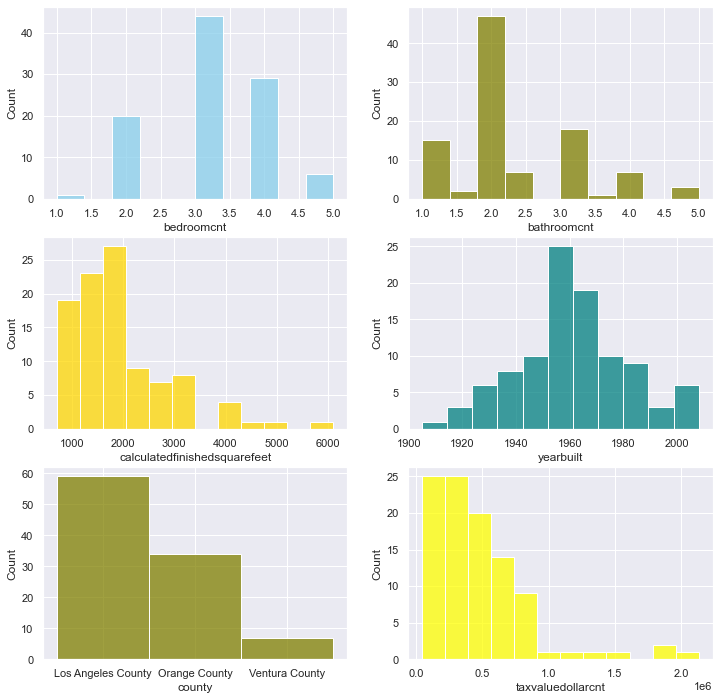

In [3]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

sns.histplot(data=train.sample(100), x="bedroomcnt", color="skyblue", ax=axs[0, 0])
sns.histplot(data=train.sample(100), x="bathroomcnt", color="olive", ax=axs[0, 1])
sns.histplot(data=train.sample(100), x="calculatedfinishedsquarefeet", color="gold", ax=axs[1, 0])
sns.histplot(data=train.sample(100), x="yearbuilt",  color="teal", ax=axs[1, 1])
sns.histplot(data=train.sample(100), x="county",  color="olive", ax=axs[2, 0 ])
sns.histplot(data=train.sample(100), x="taxvaluedollarcnt",  color="yellow", ax=axs[2, 1])

plt.show()

### <center> <u>Summary of Exploration:</u><br> <br>Things to notice, but not be fooled by...<br><br>The above chart can give us some insights into what buyers might be looking for when purchasing a Single Family property, however, we have to consider other factors that come into play, and can really only understand that through hypothesis testing.

_________________________________________________________________________________________________________________

# Hypothesis Testing:

### Questions 1: Does Bathroom count determine a property's value?

a = 0.05

- H0: Bathroom count is not linearly dependant on property value.
- Ha: Bathroom count is linearly dependant property value.

In [4]:
#We will try a correlation hypothesis test for bathroom count and taxvaluedollarcnt (property value)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.bathroomcnt
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)


The correlation coefficient is: 0.5059773252754048


### The Correlation Coefficient is showing that Bathroom IS a moderately strong positive coefficient to Property Value.

In [5]:
#How to calculate the corresponding p-value:

# 1 step: create a t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)

# 2 step: find the p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test

# 3 step: Compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α

if p < α:
    print('We reject the null Hypothesis')

We reject the null Hypothesis


## Summary of other Hypothesis Tests:
- Bedroom count also rejected the null hypothesis, yet the correlation coefficient score was only 0.26, so much weaker of a coefficien than bathrooms even.

___________________________________________________________________________________________________________

# Creating, Fitting and Trying out Models:
I had created and tried 5 different kinds of models:
- OLS Regression(RMSE)
- LassoLars
- TweedieRegressor(GLM)
- Polynomial Features (2 & 3 degree versions)

### Each model I had evaluated using RMSE (squares errors to be larger to easily compare) and keep in a dollar-value when it came to reading errors.

In [6]:
#dropped columns so as to fit model onto data
from evaluate import drop_columns_ols
drop_columns_ols(train, validate, test)

#creating copies of train to rename
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

#final name for df, to fit model onto data
X_train = train_scaled[['calculatedfinishedsquarefeet']]
y_train = train_scaled['taxvaluedollarcnt']

X_validate = validate_scaled[[ 'calculatedfinishedsquarefeet']]
y_validate = validate_scaled['taxvaluedollarcnt']

X_test = test_scaled[['calculatedfinishedsquarefeet']]
y_test = test_scaled['taxvaluedollarcnt']



## Creating & Fitting my OLS Regression Model:

In [7]:
from sklearn.linear_model import LinearRegression
# create the model object and fit the model to train_scaled data
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_train)

## Creating the zillow predictor baseline aka mean, of taxvaluedollarcnt(y)

In [8]:
baseline = train_scaled.taxvaluedollarcnt.mean()
train_scaled['yhat'] = predictions

#let's add the baseline to the the dataframe
train_scaled['baseline'] = train_scaled.taxvaluedollarcnt.mean()
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,county,yhat,baseline
25905,2,1.0,1024,527930,1948.0,6037,Los Angeles County,241354.241251,468597.876565
48178,3,2.0,1490,245594,1973.0,6059,Orange County,365016.255566,468597.876565
17604,2,2.0,1511,263518,1987.0,6111,Ventura County,370589.007284,468597.876565
47004,2,2.0,1327,319934,1949.0,6037,Los Angeles County,321761.087469,468597.876565
39460,3,2.0,2190,279574,1982.0,6037,Los Angeles County,550774.646168,468597.876565


## Plotting Residuals for the OLS Model:

In [9]:
# first I need to create residuals (ie residuals = actual - predicted)
train_scaled['residual'] = train_scaled.taxvaluedollarcnt - train_scaled.yhat
train_scaled['baseline_residual'] = train_scaled.taxvaluedollarcnt - train_scaled.baseline
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,county,yhat,baseline,residual,baseline_residual
25905,2,1.0,1024,527930,1948.0,6037,Los Angeles County,241354.241251,468597.876565,286575.758749,59332.123435
48178,3,2.0,1490,245594,1973.0,6059,Orange County,365016.255566,468597.876565,-119422.255566,-223003.876565
17604,2,2.0,1511,263518,1987.0,6111,Ventura County,370589.007284,468597.876565,-107071.007284,-205079.876565
47004,2,2.0,1327,319934,1949.0,6037,Los Angeles County,321761.087469,468597.876565,-1827.087469,-148663.876565
39460,3,2.0,2190,279574,1982.0,6037,Los Angeles County,550774.646168,468597.876565,-271200.646168,-189023.876565


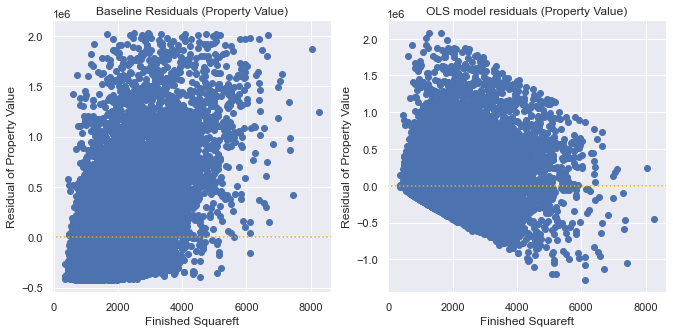

In [10]:
#Let's plot!
#Here are the residual plots (calculated finished square feet vs residual)

###METHODS USED:

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.baseline_residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('Baseline Residuals (Property Value)')

plt.subplot(122)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('OLS model residuals (Property Value)');

## Evaluating the Model Statistically (Variance Score for accuracy of prediction of movement of errors

In [11]:
from sklearn.metrics import explained_variance_score
#creating an explained variance score to determine the dipersion of errors in the data set
## (aka, how much of the data the model can accurately predict...)
evs = explained_variance_score(train_scaled.taxvaluedollarcnt, train_scaled.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.337


## Using RSME to bring back larger errors that are easier to read/spot AND sends back the errors in real-time terms: Money

In [24]:
# Here I calculated the square of residuals (makes all the residuals positive)
#Had to pull this in manually as I changed something on the py function that needs to be adjusted.

train_scaled['residual^2'] = train_scaled.residual**2
train_scaled['baseline_residual^2'] = train_scaled.baseline_residual**2

#SUM OF SQUARED ERRORS:
SSE = train_scaled['residual^2'].sum()
SSE_baseline = train_scaled['baseline_residual^2'].sum()

#MEAN OF SQUARED ERROR: (error at each observation level)
MSE = SSE/len(train_scaled)
MSE_baseline = SSE_baseline/len(train_scaled)

#ROOT MEAN SQUARED ERROR
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))



RMSE =  315754.6
RMSE baseline =  387904.2


## TAKE AWAY: 
### The OLS model is still returning 315_754 margin of error. 
    However, since the current model has a 387_904 margin of error,
    This gives our model a lead of 72_150.

________________________________________________________________________________________________________________

In [25]:
from sklearn.metrics import mean_squared_error
RMSE2 = sqrt(mean_squared_error(train_scaled.taxvaluedollarcnt, train_scaled.yhat))
RMSE2_baseline = sqrt(mean_squared_error(train_scaled.taxvaluedollarcnt, train_scaled.baseline))

print("RMSE manual == RMSE skearn: ", RMSE == RMSE2) 
print("RMSE manual - baseline == RMSE skearn - baseline: ", RMSE_baseline == RMSE2_baseline) 


RMSE manual == RMSE skearn:  True
RMSE manual - baseline == RMSE skearn - baseline:  True


Text(103, 90, '')

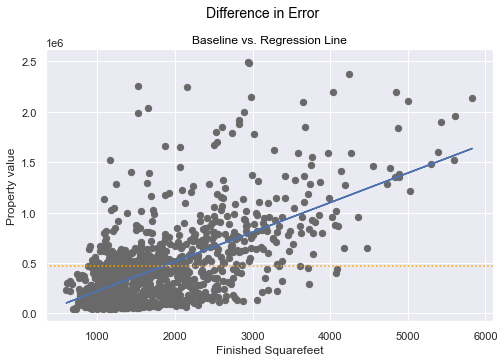

In [42]:
sample = train_scaled.sample(1000)
baseline = sample.baseline
yhat = sample.yhat
x = sample.calculatedfinishedsquarefeet
y = sample.taxvaluedollarcnt
plt.figure(figsize=(8, 5))

## plot data points, regression line and baseline
    # plot the data points 
plt.scatter(x, y, color='dimgray', s=40)

#### plot the regression line
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

# add baseline through annotation
# for each x apply y to make line across chart
plt.axhline(train_scaled.taxvaluedollarcnt.mean(), ls = ':', color ='orange')
#### set and plot title, subtitle, and axis labels
# set titles
title_string = r'Difference in Error'
subtitle_string = "Baseline vs. Regression Line"

    # add titles
plt.title(subtitle_string, fontsize=12, color='black')
plt.suptitle(title_string, y=1, fontsize=14, color='black')
    
    # add axes labels
plt.ylabel('Property value')
plt.xlabel('Finished Squarefeet')

# annotate some of the error lines with pointers
    # add pointer: the first data point to the regression line
plt.annotate('.', xy=(70.25, 70), xytext=(73, 70), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the regression line
plt.annotate('', xy=(100.25, 97), xytext=(103, 97), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the baseline 
plt.annotate('', xy=(100.25, 90), xytext=(103, 90), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'goldenrod', 'linewidth': 1})


### I worry about with the multicollinearity warning, however this warning showed up for each of my models, so I will move forward anyways.

## Take Away: 
- I chose this model as it proved to be better than the baseline 
    - <b>Rejected null
    - <b>33% variance accuracy of data
    - <b>Giving us 72_150 more to work with when it comes to estimating property values

## NEXT STEPS:
- Assessing more feature drivers to property value
    - more specific on which ones deliver how much more value when added/not included

<img src="https://play-lh.googleusercontent.com/dKL38bnxOQTTyG9dB467IfCYF0gHWZROJeDUiSGEuVrjaSIHbjDr9T6P6y1OrB_KAQ" title="house" width="100" height="40"/>